In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from scipy import stats

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
data_url = 'https://gitlab.com/yuxuan.chen/storage/'\
    '-/raw/master/IPADS-2019/week2/data.csv'
data = pd.read_csv(data_url)

# remove useless columns
data.drop(['Unnamed: 32', 'id'], axis=1, inplace=True)
print(data.describe())

       radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

In [3]:
# re-encode
data['diagnosis'].replace('M', 1, inplace=True)
data['diagnosis'].replace('B', 0, inplace=True)
data_mal = data[data['diagnosis'] == 1]
data_ben = data[data['diagnosis'] == 0]
x = data.drop(['diagnosis'], axis=1)
y = data['diagnosis']

In [4]:
# split data train 80% and test 20%
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.2, random_state=42)

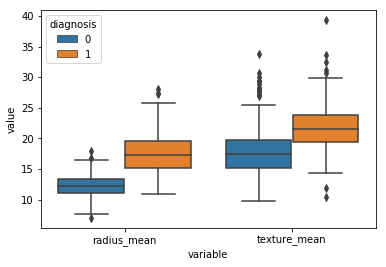

In [5]:
# box-plot to observe outliers
melted_data = pd.melt(frame=data, 
                      id_vars='diagnosis', 
                      value_vars=['radius_mean', 'texture_mean'])
plt.figure(figsize = (6, 4))
seaborn.boxplot(x='variable', 
                y='value', 
                hue='diagnosis', 
                data=melted_data)
plt.show()

In [6]:
# effect size
mean_diff = data_mal.radius_mean.mean() - data_ben.radius_mean.mean()
var_ben = data_ben.radius_mean.var()
var_mal = data_mal.radius_mean.var()
var_pooled = (len(data_ben) * var_ben + len(data_mal) * var_mal) \
             / float(len(data_ben) + len(data_mal))
effect_size = mean_diff / np.sqrt(var_pooled)
print('Effect size:', effect_size)

Effect size:  2.2048585165041414


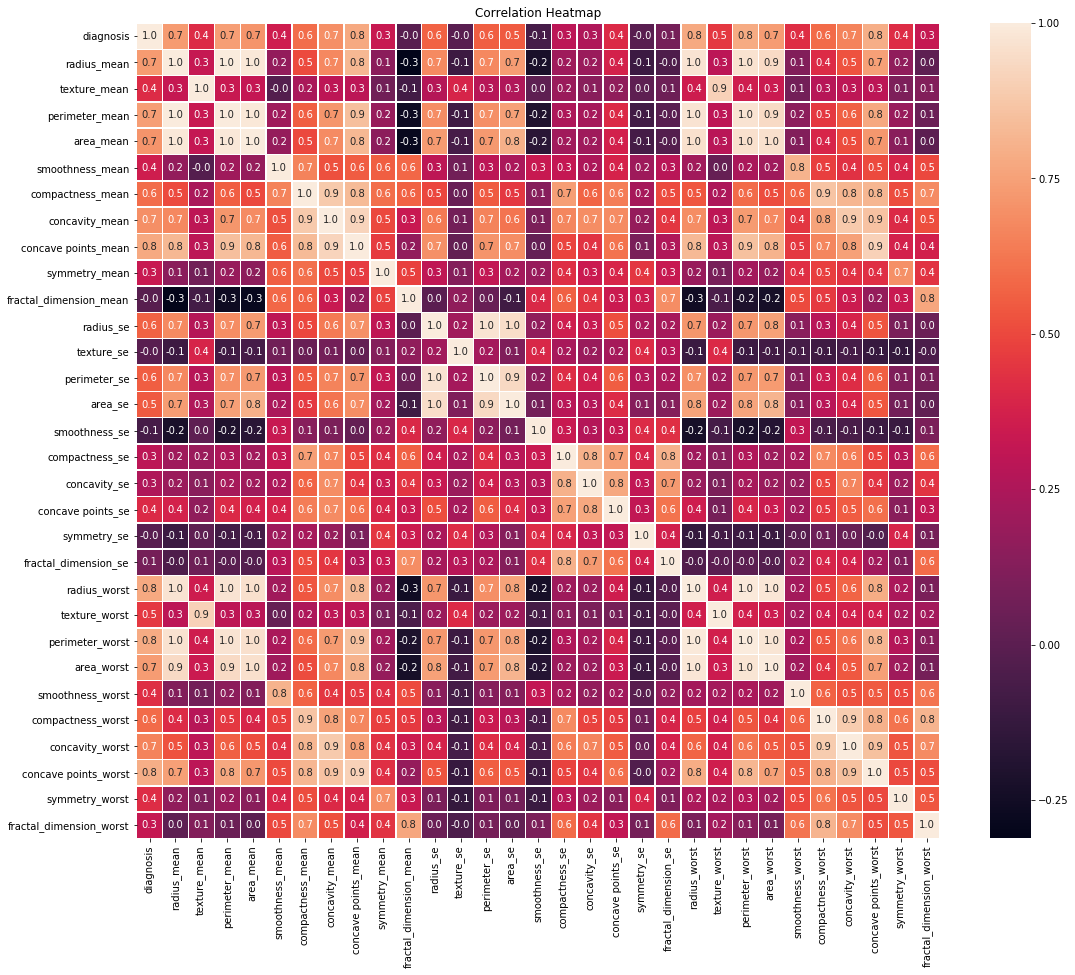

symmetry_se                0.006522
texture_se                 0.008303
fractal_dimension_mean     0.012838
smoothness_se              0.067016
fractal_dimension_se       0.077972
concavity_se               0.253730
compactness_se             0.292999
fractal_dimension_worst    0.323872
symmetry_mean              0.330499
smoothness_mean            0.358560
concave points_se          0.408042
texture_mean               0.415185
symmetry_worst             0.416294
smoothness_worst           0.421465
texture_worst              0.456903
area_se                    0.548236
perimeter_se               0.556141
radius_se                  0.567134
compactness_worst          0.590998
compactness_mean           0.596534
concavity_worst            0.659610
concavity_mean             0.696360
area_mean                  0.708984
radius_mean                0.730029
area_worst                 0.733825
perimeter_mean             0.742636
radius_worst               0.776454
concave points_mean        0

In [7]:
# correlation heatmap and numerics
f,ax=plt.subplots(figsize = (18,15))
seaborn.heatmap(data=data.corr(), 
                annot=True, 
                linewidths=0.5, 
                fmt = '.1f', 
                ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Heatmap')
plt.show()
corr = data.corr()['diagnosis'].abs().sort_values()
print(corr)

In [8]:
# feature selection(fs)
drop_list = ['perimeter_mean', 'radius_mean', 'compactness_mean', \
             'concave points_mean', 'radius_se', 'perimeter_se', \
             'radius_worst', 'perimeter_worst', 'compactness_worst', \
             'concave points_worst', 'compactness_se', \
             'concave points_se', 'texture_worst', 'area_worst']
x_train_fs = x_train.drop(drop_list,axis = 1)
x_test_fs = x_test.drop(drop_list,axis = 1)

In [9]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is prop. to the number of correct classifications
clf_rf = RandomForestClassifier()

# 5-fold cross-validation
rfecv = RFECV(estimator=clf_rf, step=1, cv=5,scoring='accuracy')
rfecv = rfecv.fit(x_train_fs, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train_fs.columns[rfecv.support_])

Optimal number of features : 12
Best features : Index(['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'fractal_dimension_mean', 'area_se', 'concavity_se',
       'fractal_dimension_se', 'smoothness_worst', 'concavity_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


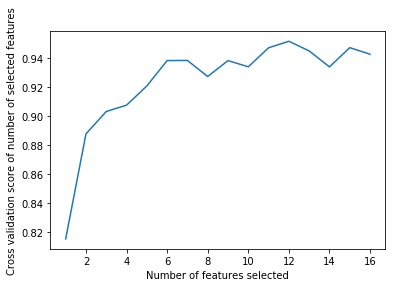

In [10]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [11]:
# further feature selection(fs)
drop_list = ['fractal_dimension_mean', 'texture_se', 'smoothness_se']
x_train_fs = x_train.drop(drop_list,axis = 1)
x_test_fs = x_test.drop(drop_list,axis = 1)

In [12]:
# RF for feature selection
classifier = RandomForestClassifier(n_estimators=10, 
                                    criterion='entropy', 
                                    random_state=0)      
classifier = classifier.fit(x_train_fs, y_train)
accuracy = accuracy_score(y_test, classifier.predict(x_test_fs))
print('Accuracy of RF for feature selection is:', accuracy)

Accuracy of RF for feature selection is:  0.9736842105263158


In [13]:
# SVM for feature selection
classifier = sklearn.svm.SVC(kernel='linear', 
                             C=0.1, 
                             gamma=10, 
                             probability=True)
classifier.fit(x_train_fs, y_train)
prediction = classifier.predict(x_test_fs)
accuracy = accuracy_score(prediction, y_test)
print('Accuracy of SVM for feature selection is:', accuracy)

Accuracy of SVM for feature selection is:  0.9649122807017544


[4.35027816e-01 1.95000069e-01 9.78151887e-02 6.48640944e-02
 5.25337760e-02 4.11279962e-02 2.23559034e-02 1.64795219e-02
 1.38005190e-02 1.20526216e-02 1.05656532e-02 8.83487978e-03
 7.72384348e-03 5.31689053e-03 2.90035907e-03 2.74863963e-03
 2.02120554e-03 1.81312048e-03 1.63703163e-03 1.03921453e-03
 9.98523858e-04 8.78835623e-04 8.09819261e-04 5.76666950e-04
 4.96295906e-04 2.76290404e-04 2.25813282e-04 5.07660981e-05
 2.45885848e-05 4.05623540e-06]


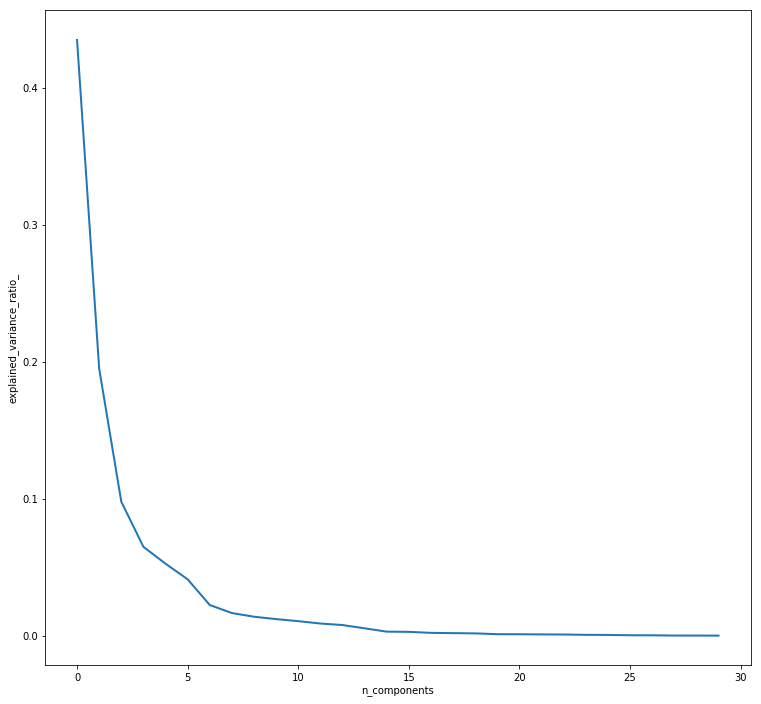

In [14]:
# PCA analysis
scaler = StandardScaler()
x_train_fe = scaler.fit_transform(x_train)
x_test_fe = scaler.fit_transform(x_test)
pca = PCA()
pca.fit(x_train_fe)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
print(pca.explained_variance_ratio_)

k= 1 , Accuracy of RF is:  0.9035087719298246
k= 1 , Accuracy of SVM is:  0.9298245614035088
k= 2 , Accuracy of RF is:  0.9736842105263158
k= 2 , Accuracy of SVM is:  0.9736842105263158
k= 3 , Accuracy of RF is:  0.9298245614035088
k= 3 , Accuracy of SVM is:  0.9649122807017544
k= 4 , Accuracy of RF is:  0.9473684210526315
k= 4 , Accuracy of SVM is:  0.9649122807017544
k= 5 , Accuracy of RF is:  0.9122807017543859
k= 5 , Accuracy of SVM is:  0.9824561403508771
k= 6 , Accuracy of RF is:  0.9385964912280702
k= 6 , Accuracy of SVM is:  0.9824561403508771
k= 7 , Accuracy of RF is:  0.9473684210526315
k= 7 , Accuracy of SVM is:  0.9824561403508771
k= 8 , Accuracy of RF is:  0.9473684210526315
k= 8 , Accuracy of SVM is:  0.9736842105263158
k= 9 , Accuracy of RF is:  0.9473684210526315
k= 9 , Accuracy of SVM is:  0.9912280701754386
k= 10 , Accuracy of RF is:  0.9385964912280702
k= 10 , Accuracy of SVM is:  0.9912280701754386
k= 11 , Accuracy of RF is:  0.9385964912280702
k= 11 , Accuracy of S

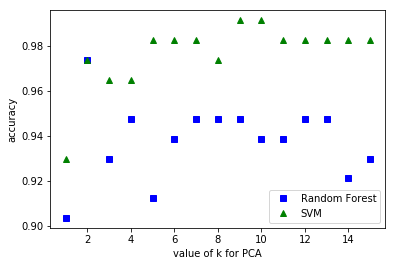

In [15]:
# select optimal k for PCA
rf_results, svm_results = [], []
for k in range(1, 16):
    pca = PCA(n_components=k)
    x_train_fe_ = pca.fit_transform(x_train_fe)
    x_test_fe_ = pca.transform(x_test_fe)
    
    # RF + PCA
    classifier = RandomForestClassifier(n_estimators=10, 
                                        criterion='entropy', 
                                        random_state=0)
    classifier.fit(x_train_fe_, y_train)
    y_pred = classifier.predict(x_test_fe_)
    accuracy = accuracy_score(y_test, y_pred)
    rf_results.append(accuracy)
    print('k=', k, ', Accuracy of RF is:', accuracy)
    
    # SVM + PCA
    classifier = sklearn.svm.SVC(kernel='linear', 
                                C=0.1, 
                                gamma=10, 
                                probability=True)
    classifier.fit(x_train_fe_, y_train)
    prediction = classifier.predict(x_test_fe_)
    accuracy = accuracy_score(prediction, y_test)
    svm_results.append(accuracy)
    print('k=', k, ', Accuracy of SVM is:', accuracy)

# plot the influence of k
x = np.arange(1, 16)
plt.plot(x, rf_results, 'bs', label='Random Forest')
plt.plot(x, svm_results, 'g^', label='SVM')

plt.xlabel('value of k for PCA')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [16]:
# top k for feature extraction(fe)
pca = PCA(n_components=2)
x_train_fe = pca.fit_transform(x_train_fe)
x_test_fe = pca.transform(x_test_fe)

In [17]:
# RF for feature extraction 
classifier = RandomForestClassifier(n_estimators=10, 
                                    criterion='entropy', 
                                    random_state=0)
classifier.fit(x_train_fe, y_train)
y_pred = classifier.predict(x_test_fe)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of RF for feature extraction is:', accuracy)

Accuracy of RF for feature extraction is:  0.9736842105263158


In [18]:
# SVM for feature extraction
classifier = sklearn.svm.SVC(kernel='linear', 
                             C=0.1, 
                             gamma=10, 
                             probability=True)
classifier.fit(x_train_fe, y_train)
prediction = classifier.predict(x_test_fe)
accuracy = accuracy_score(prediction, y_test)
print('Accuracy of SVM for feature extraction is:', accuracy)

Accuracy of SVM for feature extraction is:  0.9736842105263158
